## Notebook Initialization

In [877]:
%load_ext autoreload
import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [878]:
%matplotlib inline

In [879]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

from astropy.io import fits

import numpy as np
import copy
import pickle
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy import optimize


import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
from darkhistory.history.tla import get_history

import main
import config

In [880]:
f_elec_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_elec_swave.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1]

f_phot_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_phot_swave.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1]

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(config.data_path+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

#Derived from Planck 2018 cosmological parameters
p_ann = 3.5e-28

def xsec_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def xsec_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]

In [881]:
struct_boost_einasto_subs = phys.struct_boost_func(model='einasto_subs')

# Planck 2018 Reionization Histories

In [882]:
import darkhistory.history.reionization as reion
import csv

reion_strings = np.array(
    ['earliest', 'latest', 'FlexKnot_early', 'FlexKnot_late','FlexKnot_early_1sig', 'FlexKnot_late_1sig', 'Tanh_early', 'Tanh_late', 'Tanh_early_1sig', 'Tanh_late_1sig']
)

def make_reion_interp_func(string, He_bump=False):
    Planck_data = []
    with open('/Users/gregoryridgway/Dropbox (MIT)/Late_Time_Energy_Injection/reion_models/Planck_'+
              string+'.csv') as csvfile:
        reader = csv.reader(csvfile)
        reader = csv.reader(csvfile)
        for row in reader:
            Planck_data.append([float(row[0]),float(row[1])])
    Planck_data = np.array(Planck_data)

    #fix normalization
    if string == 'FlexKnot_early':
        norm_fac = Planck_data[-2,1]
    else:
        norm_fac = Planck_data[0,1]
        
        #I WebPlot Digitized poorly, so I re-zero
        if string == 'FlexKnot_late':
            Planck_data[26:,1] = 0
        elif string == 'Tanh_late':
            Planck_data[63:,1] = 0
            
        
    Planck_data[:,1] = (1+2*phys.chi)*Planck_data[:,1]/norm_fac

    #convert from z to rs
    Planck_data[:,0] = 1+Planck_data[:,0]

    fac = 2
    if He_bump == False:
        Planck_data[Planck_data[:,1]>1+phys.chi,1]=1+phys.chi
        fac = 1

    return interp1d(Planck_data[:,0], Planck_data[:,1], 
                    bounds_error=False, fill_value=(1+fac*phys.chi,0), kind='linear')

# Make interpolation functions for each Planck2018 reionization history
reion_interps = {string : make_reion_interp_func(string) for string in reion_strings}
bump_interp = make_reion_interp_func('Tanh_late', True)

# Plot the different methods
reion_rs_list = 10**np.arange(0,np.log10(25), .01)
colors = {'FlexKnot_early': 'C0',
         'FlexKnot_late': 'C0',
         'FlexKnot_early_1sig': 'C0',
         'FlexKnot_late_1sig': 'C0',
         'Tanh_early': 'k',
         'Tanh_late': 'k',
         'Tanh_early_1sig': 'k',
         'Tanh_late_1sig': 'k'}

# Ly$\alpha$ Forest Measurements

In [883]:
# List of redshifts, Average Temperatures, and error bars
z_entries=np.array([1.8,2.0,2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0,4.2,4.6,5.0,5.4])
rs_entries=1+z_entries[-7:]

new_mids=np.array([.768,.732,1.014,1.165,1.234,
          1.286,1.289,1.186,1.404,1.038,
          1.205,.940,.890,.877,.533,.599])
mids = new_mids[-7:]

high_errs = np.array([.37,.17,.25,.29,.19,.19,.18,.13,.17,.31,.23,.22,.093,.13,.12,.15])
low_errs  = np.array([.22,.091,.15,.19,.14,.15,.14,.12,.16,.27,.19,.17,.073,.11,.091,.13])
sigs = low_errs[-7:]

Gaikwad_data = np.array([[1.1, .16], [1.05, .21], [1.2, .22]])
Gaikwad_rs   = np.array([6.4,6.6,6.8])

# Fiducial Data
default_data = [
    np.concatenate((rs_entries[:-2], Gaikwad_rs)),
    (
        np.concatenate((mids[:-2], Gaikwad_data[:,0])),
        np.concatenate((high_errs[ind:-2], Gaikwad_data[:,1]))
    )
]

### Existing Constraints

In [884]:
def download_other_constr(string):
    tmp = []
    with open('Other_Constraints/'+string) as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
             tmp.append([float(row[0]),float(row[1])])
    return np.array(tmp)

voyager_conservative = download_other_constr('Voyager_conservative.csv')
brem                 = download_other_constr('brem.csv')
Cirelli_et_al        = download_other_constr('Cirelli_ann_constr.csv')
fermi_lat_pwave      = download_other_constr('fermi_lat_pwave.csv')
dsph_pwave           = download_other_constr('dSph_pwave.csv')
voyagerDecay         = download_other_constr('VoyagerDecay.csv')
fermi_decay          = download_other_constr('TelescopesDecay.csv')
decayFSR             = download_other_constr('decay_FSR.csv')

In [885]:
#Consolidate different telescope constraints for pwave
mask_brem_overlap  = brem[:,0]>fermi_lat_pwave[0,0]
length = sum(~mask_brem_overlap)+len(fermi_lat_pwave[:,0])
telescope_pwave = np.zeros((length,2))

telescope_pwave[:sum(~mask_brem_overlap)] = brem[~mask_brem_overlap]
telescope_pwave[-len(fermi_lat_pwave[:,0]):] = fermi_lat_pwave


#... and for decay
mask_FSR_overlap  = decayFSR[:,0]>fermi_decay[3,0]
length = sum(~mask_FSR_overlap)+len(fermi_decay[3:,0])
telescope_decay = np.zeros((length,2))

telescope_decay[:sum(~mask_FSR_overlap)] = decayFSR[~mask_FSR_overlap]
telescope_decay[-len(fermi_decay[3:,0]):] = fermi_decay[3:]

# New Constraints

### Download Data

In [137]:
input_dir = '/Users/gregoryridgway/Dropbox (MIT)/Late_Time_Energy_Injection/data/erebus_constraint_data/'
m_inc = 0.1
log10m = {'phot': np.arange(4.01, 12.76, m_inc), 'elec': np.arange(6.01, 12.76, m_inc)}
log10_mDM_fine = {'phot': np.arange(4.01,12.76,.1), 'elec': np.arange(6.01,12.76,.1)}

erebus_data = {}  
tmp_data = {}
for constr_str in ['FreeStream_robust', 'FreeStream_photoheat']:
    for reion_str in ['FlexKnot_early', 'FlexKnot_late', 'Tanh_early', 'Tanh_late']:
        for pri in ['elec', 'phot']:
            for DM_process in ['decay', 'pwave']:
                
                key = constr_str+'_'+reion_str+'_'+pri+'_'+DM_process
                tmp_data[key] = pickle.load(open(input_dir+'data'+key+'.dat','rb'))
                
                #A small hack since erebus didn't manage to output this single history
                if reion_str+pri+DM_process+constr_str == 'FlexKnot_earlyphotdecayFreeStream_photoheat':
                    tmp_data[key] = pickle.load(open(input_dir+'data'+constr_str+'_FlexKnot_late_'+pri+'_'+DM_process+'.dat','rb'))

                erebus_data[key] = np.zeros_like(log10m[pri])
                    
                for i in np.arange(len(erebus_data[key])):
                    erebus_data[key][i] = interp1d(
                        tmp_data[key][0][i], tmp_data[key][1][i][:-1]
                    )(10.1522)                

In [259]:
input_dir = '/Users/gregoryridgway/Dropbox (MIT)/Late_Time_Energy_Injection/data/Tm_constraints_tol_1e-6_photoheating_prior/'
m_inc = 0.2
log10m_tigress = {'phot': np.arange(4.01, 12.76, m_inc), 'elec': np.arange(6.01, 12.76, m_inc)}
log10_mDM_fine = {'phot': np.arange(4.01,12.76,.1), 'elec': np.arange(6.01,12.76,.1)}

tigress_data = {}  
tmp_data = {}
for constr_str in ['FreeStream_photoheated1', 'FreeStream_photoheated2']:
    for reion_str in ['FlexKnot_early', 'FlexKnot_late', 'Tanh_early', 'Tanh_late']:
        for pri in ['elec', 'phot']:
            for DM_process in ['decay', 'pwave']:
                
                key = constr_str+'_'+reion_str+'_'+pri+'_'+DM_process
                tmp_data[key] = pickle.load(open(input_dir+'data'+key+'.dat','rb'))
                
#                 A small hack since erebus didn't manage to output this single history
                if key == 'FreeStream_photoheated2_FlexKnot_early_elec_pwave':
#                     print(np.array(tmp_data[key])[-1][-5:])
                    tmp_data[key] = np.array(tmp_data[key])
                    tmp_data[key][:][-5:] = np.array(pickle.load(open(
                        input_dir+'data'+constr_str+'_Tanh_early_'+pri+'_'+DM_process+'.dat','rb')))[:][-5:]
#                     tmp_data[key] = pickle.load(open(input_dir+'data'+constr_str+'_Tanh_early_'+pri+'_'+DM_process+'.dat','rb'))
            
#                 print(key, tmp_data[key][-1][-1:])
                

                tigress_data[key] = np.zeros_like(log10m_tigress[pri])
                    
                for i in np.arange(len(tigress_data[key])):
                    tigress_data[key][i] = interp1d(
                        tmp_data[key][0][i], tmp_data[key][1][i][:-1]
                    )(10.1522)  

In [291]:
# tmp_func = interp1d(log10m['elec'], erebus_data['FreeStream_robust_Tanh_early_elec_decay'], kind='linear')
# pickle.dump(tmp_func, open('/Users/gregoryridgway/Dropbox (MIT)/Late_Time_Energy_Injection/Cross_Checks/conservative_Tanh_early_constr_func.p','wb'))
# pickle.dump(log10m['elec'], open('/Users/gregoryridgway/Dropbox (MIT)/Late_Time_Energy_Injection/Cross_Checks/mass_points.p','wb'))

In [48]:
guess_func = {}
for part in ['elec', 'phot']:
    for inj_ty in ['decay', 'pwave']:
        guess_func[part+'_'+inj_ty] = interp1d(log10m[part], erebus_data['FreeStream_photoheat_Tanh_late_'+part+'_'+inj_ty], kind=kind)
        pickle.dump(guess_func, open('/Users/gregoryridgway/Desktop/DM/DH/DarkHistory/examples/guess_funcs.p','wb'))

In [741]:
guess_func = {}
m_inc = 0.1
log10m = {'phot': np.arange(4.01, 12.76, m_inc), 'elec': np.arange(6.01, 12.76, m_inc)}
for constr_str in ['FreeStream_robust', 'FreeStream_photoheat']:
    for reion_str in ['FlexKnot_early', 'FlexKnot_late', 'Tanh_early', 'Tanh_late']:
        for pri in ['elec', 'phot']:
            for DM_process in ['decay', 'pwave']:
                key1 = constr_str+'_'+reion_str+'_'+pri+'_'+DM_process
                if constr_str == 'FreeStream_robust':
                    key2 = 'conservative_'+reion_str+'_'+pri+'_'+DM_process
                if constr_str == 'FreeStream_photoheat':
                    key2 = 'photoheated_'+reion_str+'_'+pri+'_'+DM_process
                guess_func[key2] = interp1d(log10m[pri], erebus_data[key1], kind=kind)
pickle.dump(guess_func, open(
    '/Users/gregoryridgway/Desktop/DM/DH/DarkHistory/examples/guess_funcs.p','wb'))

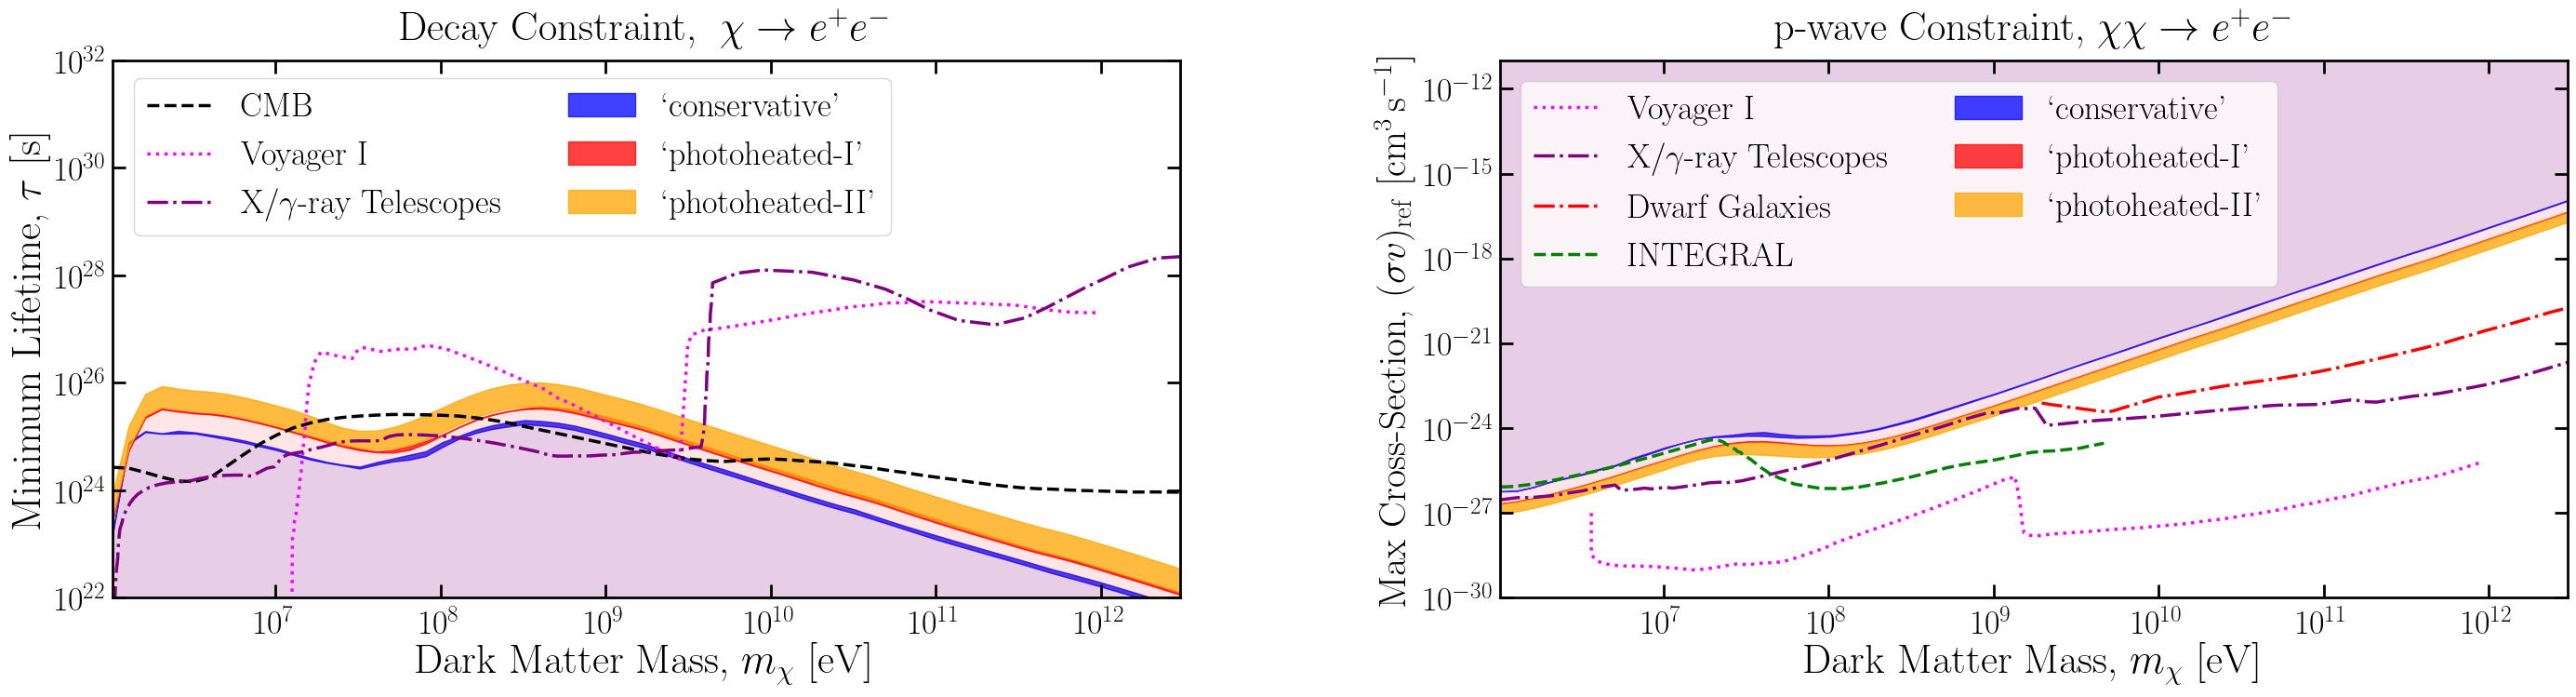

In [871]:
fig, axarr = plt.subplots(1, 2, figsize=(15,7.5))
# fig, axarr = plt.subplots(2, 2, figsize=(15,16))

log10_m_chi_arr = {'phot': np.arange(4.01, 12.76, m_inc), 
                   'elec': np.arange(6.01, 12.76, m_inc)}
log10_mDM_fine = {'phot': np.arange(4.01,12.76,.1), 'elec': np.arange(6.01,12.76,.1)}
xsec_bound_CMB = {'phot': xsec_bound_phot_CMB, 'elec': xsec_bound_elec_CMB}

plt_colors = {'FreeStream_robust' : 'blue',
              'FreeStream_photoheat' : 'red'}
plt_label = {'FreeStream_robust': "`conservative'",
            'FreeStream_photoheat' : "`photoheated' $\dot{T}^\star$"}
plt_style = {'Flex_early': 'solid', 'Flex_late': 'dashdot', 
             'Tanh_early': 'solid', 'Tanh_late': 'dashdot'}

tigress_colors = {'FreeStream_photoheated1' : 'red',
              'FreeStream_photoheated2' : 'orange'}
tigress_label = {'FreeStream_photoheated1' : "`photoheated-I'",
              'FreeStream_photoheated2' : "`photoheated-II'"}

data={}

for j, part in enumerate(['elec']):#, 'phot']):
    for k, inj_ty in enumerate(['decay', 'pwave']):
        ind = k
        axarr[ind].loglog()
        extra=part+'_'+inj_ty
            
        hist_list = {constr : [
            erebus_data[constr+'_FlexKnot_early_'+extra],
            erebus_data[constr+'_FlexKnot_late_'+extra],
            erebus_data[constr+'_Tanh_early_'+extra],
            erebus_data[constr+'_Tanh_late_'+extra]
        ] for constr in ['FreeStream_robust', 'FreeStream_photoheat']}
        
        tigress_list = {constr : [
            tigress_data[constr+'_FlexKnot_early_'+extra],
            tigress_data[constr+'_FlexKnot_late_'+extra],
            tigress_data[constr+'_Tanh_early_'+extra],
            tigress_data[constr+'_Tanh_late_'+extra]
        ] for constr in ['FreeStream_photoheated1', 'FreeStream_photoheated2']}
        
        for constr in ['FreeStream_robust']:#, 'FreeStream_photoheat']:
            
            kind='cubic'

            minfunc = interp1d(log10m[part], np.min(hist_list[constr], axis=0), kind=kind)
            maxfunc = interp1d(log10m[part], np.max(hist_list[constr], axis=0), kind=kind)
            axarr[ind].fill_between(10**log10_mDM_fine[part][:-2], 
                                     10**minfunc(log10_mDM_fine[part][:-2]), 
                                     10**maxfunc(log10_mDM_fine[part][:-2]),
                                     color=plt_colors[constr], alpha=0.75, label=plt_label[constr])

            if inj_ty == 'decay':
                axarr[ind].fill_between(10**log10_mDM_fine[part][:-2], 
                         10**minfunc(log10_mDM_fine[part][:-2]), 
                         np.ones_like(log10_mDM_fine[part][:-2])*1e10,
                         color=plt_colors[constr], alpha=0.1
                )
            else:
                axarr[ind].fill_between(10**log10_mDM_fine[part][:-2],  
                         np.ones_like(log10_mDM_fine[part][:-2])*1e-10,
                         10**maxfunc(log10_mDM_fine[part][:-2]),
                         color=plt_colors[constr], alpha=0.1
                )
            
        for constr in ['FreeStream_photoheated1', 'FreeStream_photoheated2']:

            minfunc = interp1d(log10m_tigress[part], np.min(tigress_list[constr], axis=0), kind=kind)
            maxfunc = interp1d(log10m_tigress[part], np.max(tigress_list[constr], axis=0), kind=kind)
            axarr[ind].fill_between(10**log10_mDM_fine[part][:-2], 
                                     10**minfunc(log10_mDM_fine[part][:-2]), 
                                     10**maxfunc(log10_mDM_fine[part][:-2]),
                                     color=tigress_colors[constr], alpha=0.75, label=tigress_label[constr])
            if constr == 'FreeStream_photoheated1': 
                if inj_ty == 'decay':
                    axarr[ind].fill_between(10**log10_mDM_fine[part][:-2], 
                             10**minfunc(log10_mDM_fine[part][:-2]), 
                             np.ones_like(log10_mDM_fine[part][:-2])*1e10,
                             color=tigress_colors[constr], alpha=0.1
                    )
                else:
                    axarr[ind].fill_between(10**log10_mDM_fine[part][:-2],  
                             np.ones_like(log10_mDM_fine[part][:-2])*1e-10,
                             10**maxfunc(log10_mDM_fine[part][:-2]),
                             color=tigress_colors[constr], alpha=0.1
                    )
        
            
        axarr[ind].set_xlabel(r'Dark Matter Mass, $m_\chi$ [eV]', fontsize=32)
        if inj_ty != 'pwave':
            CMB_data = [xsec_bound_CMB[part](mDM, inj_ty) for mDM in 10**log10_mDM_fine[part]]
            if part == 'phot':
                CMB_data[-4]/=10
                CMB_data[-3]/=10
            axarr[ind].plot(10**log10_mDM_fine[part], CMB_data, color='k', linestyle='--', label='CMB')
            
            if part == 'elec':
                axarr[ind].plot(np.insert(voyagerDecay[:,0], 0, 1.253e7), 
                                np.insert(voyagerDecay[:,1], 0, 1e21),
                              color='magenta', linestyle=':', label='Voyager I')
                axarr[ind].plot(telescope_decay[:,0], telescope_decay[:,1],
                              color='purple', linestyle='dashdot', label='X/$\gamma$-ray Telescopes')
                
        else:
            if part == 'elec':
                dirac_fac = 1/2
                axarr[ind].plot(np.insert(voyager_conservative[:,0], 0, 3.66e6), 
                                np.insert(dirac_fac*voyager_conservative[:,1]*(1e7/phys.c)**(2), 0, 1e-27), 
                              color='magenta', linestyle=':', label='Voyager I')
                axarr[ind].plot(telescope_pwave[:,0], telescope_pwave[:,1]*(2.2)**2, 
                              color='purple', linestyle='dashdot', label='X/$\gamma$-ray Telescopes')
                axarr[ind].plot(dsph_pwave[:,0], dsph_pwave[:,1], 
                              color='red', linestyle='dashdot', label='Dwarf Galaxies')
                axarr[ind].plot(Cirelli_et_al[:,0]*1e6, Cirelli_et_al[:,1]*(2.2)**2,
                              color='green', linestyle='--', label='INTEGRAL')
                

        if inj_ty == 'decay':
            if part == 'elec':
                axarr[ind].set_title(r'Decay Constraint, $\;\chi \to e^+e^-$', fontsize=32)
            else:
                axarr[ind].set_title(r'Decay Constraint,$\;\chi \to \gamma \gamma$', fontsize=32)
        else:
            if part == 'elec':
                axarr[ind].set_title(r'p-wave Constraint, $\chi\chi \to e^+e^-$', fontsize=32)
            else:
                axarr[ind].set_title(r'p-wave Constraint, $\chi\chi \to \gamma \gamma$', fontsize=32)

        if part == 'elec':
            if inj_ty == 'decay':
                axarr[ind].legend(loc=(0.02, 0.675), fontsize=26, ncol=2)
            else:
                axarr[ind].legend(loc=(0.019, 0.58), fontsize=26, ncol=2)
        else:
            if inj_ty == 'decay':
                axarr[ind].legend(loc=3,fontsize=26)
            else:
                axarr[ind].legend(loc=2,fontsize=26)
        fac = 1

    if part == 'elec':
        axarr[0].axis([10**(6.01), 3e12, 1e22,1e32])
        axarr[1].axis([10**(6.01), 3e12, 1e-30,1e-11])
    else:
        axarr[0].axis([10**(4.01), 3e12, 1e19,1e26])
        axarr[1].axis([10**(4.01), 3e12, 1e-26,1e-13])



axarr[0].set_ylabel(r'Minimum Lifetime, $\tau$ [s]', fontsize=32)
axarr[1].set_ylabel(r'Max Cross-Section, $(\sigma v)_{\mathrm{ref}}$ [cm$^3\,$s$^{-1}$]', fontsize=30)

plt.subplots_adjust(wspace=0.3, left=-.38, right=1.38)
plt.xticks()
axarr[1].xaxis.set_tick_params(which='minor', bottom=False)
axarr[1].xaxis.set_tick_params(which='minor', top=False)
axarr[0].xaxis.set_tick_params(which='minor', bottom=False)
axarr[0].xaxis.set_tick_params(which='minor', top=False)
axarr[0].yaxis.set_tick_params(which='minor', left=False)
axarr[0].yaxis.set_tick_params(which='minor', right=False)

for k in [0,1]:
    for tick in axarr[k].xaxis.get_major_ticks():
        tick.label.set_fontsize(26)
    for tick in axarr[k].yaxis.get_major_ticks():
        tick.label.set_fontsize(26)

# plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/Late_Time_Energy_Injection/Paper/figs/constraints_ee2.pdf')

# Example History

In [916]:
%autoreload
PH_FL_hist = get_his(1e4 * phys.kB, 1.5, mDM=mDM, lifetime=tau, DM_process='decay',
            fs=fs, reion_method='FlexKnot_late')

(True, array([[6.80985296e-01, 9.99960189e-01, 7.86700212e-02, 9.99998695e-13],
       [6.65604185e-01, 9.99960189e-01, 8.05207401e-02, 9.99998695e-13],
       [6.50454472e-01, 9.99960189e-01, 7.98811174e-02, 9.99998695e-13],
       ...,
       [1.38326329e+05, 9.99960189e-01, 8.11225981e-02, 8.11258278e-02],
       [2.20228853e+05, 9.99960189e-01, 8.11225981e-02, 8.11258278e-02],
       [3.50625568e+05, 9.99960189e-01, 8.11225981e-02, 8.11258278e-02]]))


/usr/local/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


TypeError: tuple indices must be integers or slices, not tuple

In [919]:
45/(2*np.pi**4) * np.sqrt(8/np.pi)

0.368598093411997

In [912]:
rs_vec = 10**np.arange(np.log10(2.9e3), np.log10(4.35), -.01)

def get_his(DeltaT, alpha, mDM=None, lifetime=None, sigmav=None, DM_process='decay',
            fs=[None, None, None, None], reion_method='FlexKnot_early'):
    
    if sigmav is not None:
        struct_boost = phys.struct_boost_func(model='pwave_NFW_no_subs')
    elif lifetime is not None:
        struct_boost = None
    else:
        struct_boost = None
        DM_process   = None
        
    tmp = get_history(
        rs_vec,
        DM_process = DM_process, mDM=mDM, lifetime=lifetime, sigmav=sigmav,
        struct_boost = struct_boost,
        f_H_ion=fs[0], f_He_ion=fs[1], f_H_exc=fs[2], f_heating=fs[3],
        reion_switch=True, reion_rs=35, reion_method=None, 
        heat_switch=True, DeltaT = DeltaT, alpha_bk=alpha,
        xe_reion_func=reion_interps[reion_method], helium_TLA=True,HeIIIcheck_switch=True,
    )
    print(tmp)
    return interp1d(rs_vec, tmp[:,0]/phys.kB*1e-4)

#Given DeltaT and alpha, find (two-sided) chi^2
def get_chisq(var, mDM=None, lifetime=None, sigmav=None, DM_process='decay',
              fs=[None, None, None, None], reion_method='FlexKnot_early'):
    DeltaT = var[0]
    alpha=var[1]
    terp = get_his(DeltaT, alpha, mDM=mDM, lifetime=lifetime, sigmav=sigmav, 
                   DM_process = DM_process, fs=fs, reion_method=reion_method)
    return sum((terp(default_data[0])-default_data[1][0])**2/default_data[1][1]**2)

#Given alpha, optimize DeltaT
def optimize_DeltaT(alpha, tol, mDM=None, lifetime=None, sigmav=None, 
                    DM_process = 'decay', fs=[None, None, None, None], reion_method='FlexKnot_early'):
    def f(DeltaT):
        return get_chisq([DeltaT,alpha], mDM=mDM, lifetime=lifetime, sigmav=sigmav, 
                         DM_process=DM_process, fs=fs, reion_method=reion_method)

    return optimize.minimize_scalar(
        f, method='bounded', bounds=[0*phys.kB, 5e4*phys.kB], options={'xatol': tol}
    )

def find_optimum(alpha_list, init, tol=0.5, mDM=None, lifetime=None, 
                 DM_process = 'decay', sigmav=None, fs=[None, None, None, None], output=False, reion_method='FlexKnot_early'):
    datums = [None for a in alpha_list]
    check_above = False
    check_below = False

    #Initialization Step
    j = init
    out = optimize_DeltaT(alpha_list[j], tol, mDM=mDM, lifetime=lifetime, sigmav=sigmav, 
                          DM_process=DM_process, fs=fs, reion_method=reion_method)
    datums[j] = [alpha_list[j], out['x']/phys.kB, out['fun']]
    count = 0
    
    #Search higher alpha
    while not check_above:
        count = count+1
        #At this point, you know the optimal value is above
        if count>1:
            check_below = True

        j = j+1
        out = optimize_DeltaT(alpha_list[j], tol, mDM=mDM, lifetime=lifetime, sigmav=sigmav,
                              DM_process=DM_process, fs=fs, reion_method=reion_method)
        datums[j] = [alpha_list[j], out['x']/phys.kB, out['fun']]
        if output:
            print(datums[j])


        if datums[j][2] > datums[j-1][2]:
            check_above=True
            j = j-1
            break
        elif j==alpha_list.size-1:
            if output:
                print('Reached maximum alpha!', datums[j])
            return np.array([datums[j],datums[j],datums[j]])
            

    #Search lower alpha
    while not check_below:
        j = j-1
        out = optimize_DeltaT(alpha_list[j], tol, mDM=mDM, lifetime=lifetime, sigmav=sigmav,
                              DM_process=DM_process, fs=fs, reion_method=reion_method)
        datums[j] = [alpha_list[j], out['x']/phys.kB, out['fun']]

        if output:
            print(datums[j])
        if datums[j][2] > datums[j+1][2]:
            check_below=True
            j = j+1
        elif j==0:
            if output:
                print('Reached minimum alpha!', datums[j])
            return np.array([datums[j],datums[j],datums[j]])
            
#     if output:
    print('Best value: ', datums[j])
#     #filter out all the None entries
#     return list(filter(None,datums))
    return np.array([datums[j-1], datums[j], datums[j+1]])


#Make the f functions
def make_fs(hist, pickleable = False):
    channels = {'heat', 'H ion', 'He ion', 'exc'}
    f_interps = {chan: interp1d(
        hist['rs'], 
        hist['f']['low'][chan]+hist['f']['high'][chan],
        bounds_error=False,
        fill_value=(
            (hist['f']['low'][chan]+hist['f']['high'][chan])[-1],
            (hist['f']['low'][chan]+hist['f']['high'][chan])[0]
        )
    ) for chan in channels}
    
    def f_Hion(rs, xHI, xHeI, xHeII):
        return f_interps['H ion'](rs)
    def f_Heion(rs, xHI, xHeI, xHeII):
        return f_interps['He ion'](rs)
    def f_exc(rs, xHI, xHeI, xHeII):
        return f_interps['exc'](rs)
    def f_heat(rs, xHI, xHeI, xHeII):
        return f_interps['heat'](rs)
     
    if pickleable:
        return f_interps
    else:
        return [f_Hion, f_Heion, f_exc, f_heat]

In [27]:
%autoreload
mDM = 1e9
tau = 5e24
DM_process='decay'
#tmp_hist Tanh_early
FlexEarly_hist = main.evolve(
    primary='elec_delta',
    DM_process=DM_process, mDM=mDM, lifetime=tau,
    reion_switch=True, reion_rs=35, helium_TLA=True,
    xe_reion_func = reion_interps['FlexKnot_early'],
    start_rs = 3e3, end_rs=4.3, DeltaT=24665*phys.kB, alpha_bk=0.57,
    heat_switch=False,
    coarsen_factor=12, backreaction=True, 
    compute_fs_method='He', mxstep=1000, rtol=1e-4,
    use_tqdm=True, cross_check = False,
    struct_boost=None
)

****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


/usr/local/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [28]:
FlexLate_hist = main.evolve(
    primary='elec_delta',
    DM_process=DM_process, mDM=mDM, lifetime=tau,
    reion_switch=True, reion_rs=35, helium_TLA=True,
    xe_reion_func = reion_interps['FlexKnot_late'],
    start_rs = 3e3, end_rs=4.3, DeltaT=24665*phys.kB, alpha_bk=0.57,
    heat_switch=False,
    coarsen_factor=12, backreaction=True, 
    compute_fs_method='He', mxstep=1000, rtol=1e-4,
    use_tqdm=True, cross_check = False,
    struct_boost=None
)

In [891]:
fs = make_fs(FlexLate_hist)
alpha_list = np.arange(-0.5,1.5,0.1)
PH_FL = find_optimum(alpha_list, init=10, mDM=mDM, DM_process=DM_process,
                    lifetime=tau, fs=fs)

PH_FL_hist = get_his(PH_FL[1,1] * phys.kB, 1.5, mDM=mDM, lifetime=tau, DM_process='decay',
            fs=fs, reion_method='FlexKnot_late')

TypeError: tuple indices must be integers or slices, not tuple

In [117]:
fs = make_fs(FlexEarly_hist)
alpha_list = np.arange(-0.5,1.5,0.1)
PH_FE = find_optimum(alpha_list, init=10, mDM=mDM, DM_process=DM_process,
                    lifetime=tau, fs=fs)

fs = make_fs(FlexEarly_hist)
get_chisq([PH_FE[1,1]*phys.kB, 1.5], mDM=mDM, lifetime=tau, DM_process='decay',
             fs=fs, reion_method='FlexKnot_early')

In [250]:
#Best-Fit
get_chisq([24665*phys.kB, 0.57], mDM=mDM, lifetime=1e100, DM_process='decay',
             fs=fs, reion_method='FlexKnot_early')

3.0335194189049877

In [192]:
fs = make_fs(FlexEarly_hist)
PH_FE_hist = get_his(0*phys.kB, 1.5, mDM=mDM, lifetime=tau, DM_process='decay',
            fs=fs, reion_method='FlexKnot_early')

NameError: name 'PH_FL_hist' is not defined

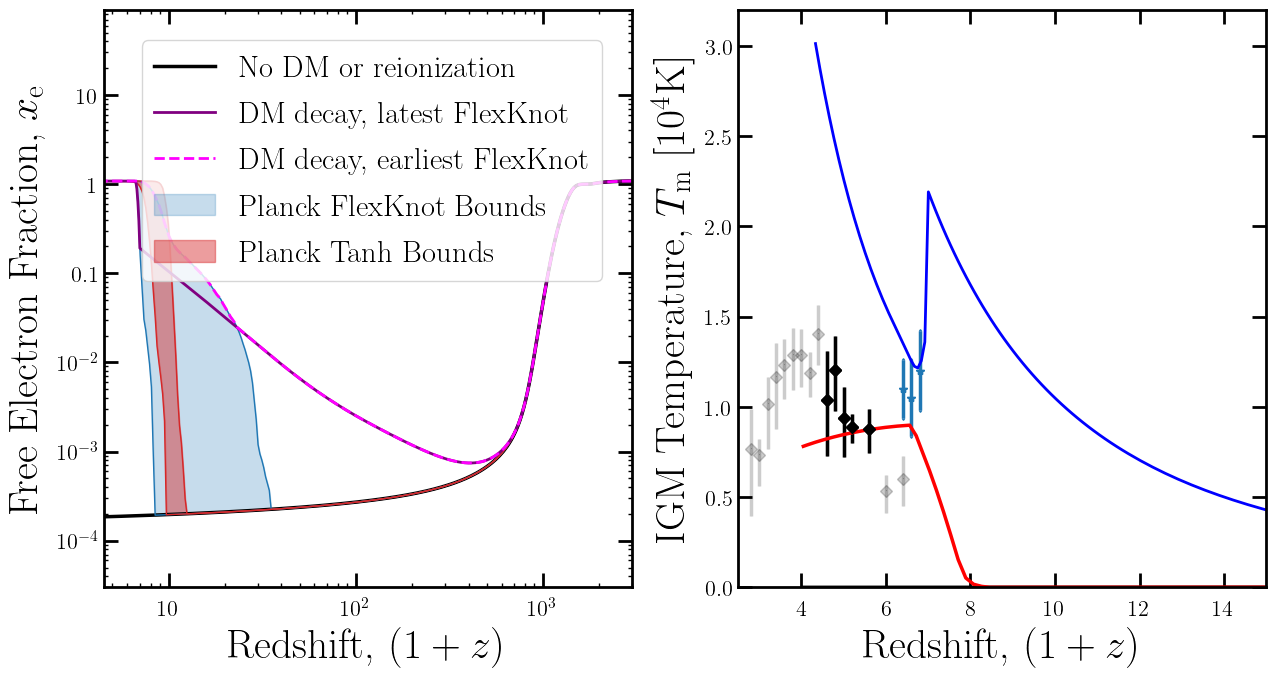

In [285]:
fig, axarr = plt.subplots(1, 2, figsize=(15,7.5))


### --- Ionization Plot --- ###
axarr[0].loglog()
axarr[0].axis([4.5,3e3,3e-5,90])

# Case (i): Baseline History
rs_list0 = 10**np.arange(np.log10(3e3)-.0001, np.log10(4.01), -.01)
history0 = get_history(rs_list0, helium_TLA=True)
axarr[0].plot(rs_list0, history0[:,1]+history0[:,2], color='k', label='No DM or reionization')

# Case (iii): 
DeltaT=24665*phys.kB
DeltaT=1.3591515614131429
alpha_bk = 1.5
alpha_bk = .65
histFE = get_history(
    rs_list0, 
    heat_switch = True, DeltaT = DeltaT, alpha_bk = alpha_bk,
    reion_switch = True, reion_rs = 35, xe_reion_func = reion_interps['FlexKnot_early']
)
histFL = get_history(
    rs_list0, 
    heat_switch = True, DeltaT = DeltaT, alpha_bk = alpha_bk,
    reion_switch = True, reion_rs = 35, xe_reion_func = reion_interps['FlexKnot_late']
)
histTE = get_history(
    rs_list0, 
    heat_switch = True, DeltaT = DeltaT, alpha_bk = alpha_bk,
    reion_switch = True, reion_rs = 35, xe_reion_func = reion_interps['Tanh_early']
)
histTL = get_history(
    rs_list0, 
    heat_switch = True, DeltaT = DeltaT, alpha_bk = alpha_bk,
    reion_switch = True, reion_rs = 35, xe_reion_func = reion_interps['Tanh_late']
)

axarr[0].plot(rs_list0[30:], histFE[30:,1]+histFE[30:,2], color='C0', linewidth=1)
axarr[0].plot(rs_list0[30:], histFL[30:,1]+histFL[30:,2], color='C0', linewidth=1)

axarr[0].fill_between(rs_list0[30:], 
 histFL[30:,1]+histFL[30:,2],
 histFE[30:,1]+histFE[30:,2],
 color='C0',
 alpha=0.25, label='Planck FlexKnot Bounds')


axarr[0].plot(rs_list0[30:], histTE[30:,1]+histTE[30:,2], color='C3', linewidth=1)
axarr[0].plot(rs_list0[30:], histTL[30:,1]+histTL[30:,2], color='C3', linewidth=1)

axarr[0].fill_between(rs_list0[30:], 
 histTL[30:,1]+histTL[30:,2],
 histTE[30:,1]+histTE[30:,2],
 color='C3',
 alpha=0.45, label='Planck Tanh Bounds')

# Case (ii) and (iv): 'robust' or 'modeled', reionization history
axarr[0].plot(FlexLate_hist['rs'], FlexLate_hist['x'][:,0]+FlexLate_hist['x'][:,1], 
              color='purple', linewidth=2, label='DM decay, latest FlexKnot', linestyle='solid')
axarr[0].plot(FlexEarly_hist['rs'], FlexEarly_hist['x'][:,0]+FlexEarly_hist['x'][:,1], 
              color='magenta', linewidth=2, label='DM decay, earliest FlexKnot', linestyle='--')


# Labels
txt = r"\begin{eqnarray*}" + \
    r"\chi &\to& e^+ e^- \\" + \
    r"m_\chi &=& 1 \,\mathrm{GeV} \\" + \
    r"\tau &=& 10^{25}\, \mathrm{s}" + \
    r"\end{eqnarray*}"


axarr[0].set_xlabel(r'Redshift, $(1+z)$', fontsize=30)
axarr[0].set_ylabel(r'Free Electron Fraction, $x_\mathrm{e}$', fontsize=30)
axarr[0].legend(fontsize=22)

### --- Temperature Plot --- ###
axarr[1].axis([2.5,15,0,3.2])
plt_ind = -7
plotline1, cap1, barlinecols1 = axarr[1].errorbar(1+z_entries, new_mids, yerr=high_errs, 
             uplims=True, fmt='D', alpha=0.2, color='k', capsize=0.1, capthick=0.1)
plotline2, cap2, barlinecols2 = axarr[1].errorbar(1+z_entries, new_mids, yerr=low_errs,  
             lolims=True, fmt=',', alpha=0.2, color='k', capsize=0.1, capthick=0.1)

plotline3, cap3, barlinecols3 = axarr[1].errorbar(1+z_entries[plt_ind:-2], new_mids[plt_ind:-2], yerr=high_errs[plt_ind:-2], 
             uplims=True, fmt='D', color='k', capsize=0.1, capthick=0.1)
plotline4, cap4, barlinecols4 = axarr[1].errorbar(1+z_entries[plt_ind:-2], new_mids[plt_ind:-2], yerr=low_errs[plt_ind:-2],  
             lolims=True, fmt=',', color='k', capsize=0.1, capthick=0.1)
axarr[1].scatter(1+z_entries[plt_ind:-2], new_mids[plt_ind:-2],  
             marker='D', color='k', label='Walther\\texttt{+}')


plotlineG1, cap2, barlinecols2 = axarr[1].errorbar(Gaikwad_rs, Gaikwad_data[:,0], yerr=Gaikwad_data[:,1],  
             lolims=True, fmt='*', color='C0', capsize=0.9, capthick=0.9)
plotlineG1, cap2, barlinecols2 = axarr[1].errorbar(Gaikwad_rs, Gaikwad_data[:,0], yerr=Gaikwad_data[:,1],  
             uplims=True, fmt='*', color='C0', capsize=0.9, capthick=0.9)
axarr[1].scatter(Gaikwad_rs, Gaikwad_data[:,0]*1e4,  
             marker='*', color='C0', label='Gaikwad\\texttt{+}')

norm = 1e-4/phys.kB
# (0) Baseline history
axarr[1].plot(rs_list0, history0[:,0]*norm, color='k')#, label="no DM decay/ann, `conservative' $\dot{T}_m^\star$")

# (i)
axarr[1].plot(FlexLate_hist['rs'], FlexLate_hist['Tm']*norm, color='blue', linewidth=2, label="$\chi \\to e^+ e^-$, `conservative' $\dot{T}^\star$")
axarr[1].plot(rs_list0, histFL[:,0]*norm, color='red',label="No DM,`photoheated' $\dot{T}^\star$")

axarr[1].set_xlabel(r'Redshift, $(1+z)$', fontsize=30)
axarr[1].set_ylabel(r'IGM Temperature, $T_\mathrm{m}$ [$10^4$K]', fontsize=30)

# (iii)
rs_vec = 10**np.arange(np.log10(2.9e3), np.log10(4.55), -.01)
axarr[1].plot(rs_vec, PH_FL_hist(rs_vec)*norm, color='purple', label="$\chi \\to e^+ e^-$, `photoheated' $\dot{T}^\star$")

axarr[1].legend(fontsize=24)

axarr[0].text(1.35e3, 2.6e-4, txt, {'color': 'black', 'fontsize': 22, 'ha': 'center', 'va': 'center'})
axarr[1].text(5.2, 2.85, '$\\textbf{Latest FlexKnot}$',
    {'color': 'black', 'fontsize': 26, 'ha': 'center', 'va': 'center'})

for k in [0,1]:
    for tick in axarr[k].xaxis.get_major_ticks():
        tick.label.set_fontsize(26)
    for tick in axarr[k].yaxis.get_major_ticks():
        tick.label.set_fontsize(26)

plt.subplots_adjust(wspace=0.3, left=-.31, right=1.31)
# plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/Late_Time_Energy_Injection/Paper/figs/example_history3.pdf')

Text(5.2, 2.85, '$\\textbf{Latest FlexKnot}$')

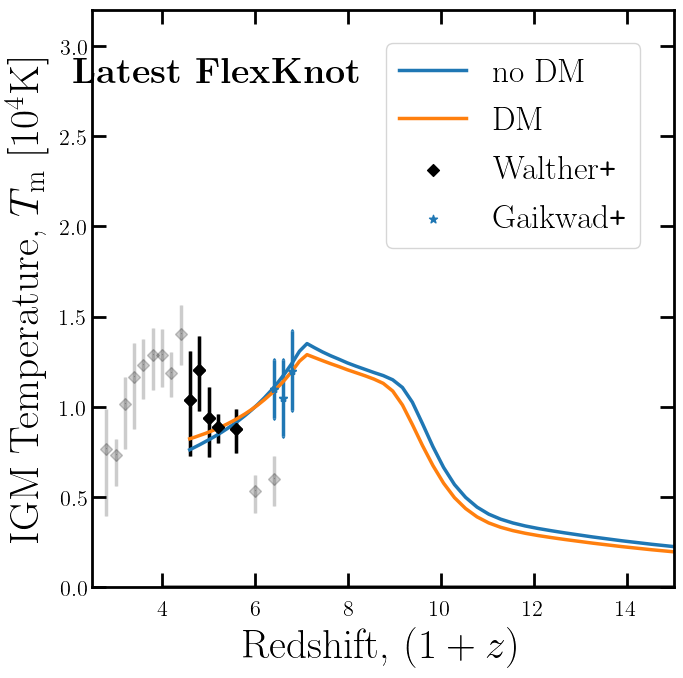

In [128]:
plt.figure(figsize=(7.5,7.5))

# Case (i): Baseline History
rs_list0 = 10**np.arange(np.log10(3e3)-.0001, np.log10(4.01), -.01)
history0 = get_history(rs_list0, helium_TLA=True)

# Case (iii): 
DeltaT=24665*phys.kB
# DeltaT=7.3e3*phys.kB
alpha_bk = 1.5
alpha_bk = .57
histFE = get_history(
    rs_list0, 
    heat_switch = True, DeltaT = DeltaT, alpha_bk = alpha_bk,
    reion_switch = True, reion_rs = 35, xe_reion_func = reion_interps['FlexKnot_early']
)
histFL = get_history(
    rs_list0, 
    heat_switch = True, DeltaT = DeltaT, alpha_bk = alpha_bk,
    reion_switch = True, reion_rs = 35, xe_reion_func = reion_interps['FlexKnot_late']
)
histTE = get_history(
    rs_list0, 
    heat_switch = True, DeltaT = DeltaT, alpha_bk = alpha_bk,
    reion_switch = True, reion_rs = 35, xe_reion_func = reion_interps['Tanh_early']
)
histTL = get_history(
    rs_list0, 
    heat_switch = True, DeltaT = DeltaT, alpha_bk = alpha_bk,
    reion_switch = True, reion_rs = 35, xe_reion_func = reion_interps['Tanh_late']
)

### --- Temperature Plot --- ###
plt.axis([2.5,15,0,3.2])
plt_ind = -7
plotline1, cap1, barlinecols1 = plt.errorbar(1+z_entries, new_mids, yerr=high_errs, 
             uplims=True, fmt='D', alpha=0.2, color='k', capsize=0.1, capthick=0.1)
plotline2, cap2, barlinecols2 = plt.errorbar(1+z_entries, new_mids, yerr=low_errs,  
             lolims=True, fmt=',', alpha=0.2, color='k', capsize=0.1, capthick=0.1)

plotline3, cap3, barlinecols3 = plt.errorbar(1+z_entries[plt_ind:-2], new_mids[plt_ind:-2], yerr=high_errs[plt_ind:-2], 
             uplims=True, fmt='D', color='k', capsize=0.1, capthick=0.1)
plotline4, cap4, barlinecols4 = plt.errorbar(1+z_entries[plt_ind:-2], new_mids[plt_ind:-2], yerr=low_errs[plt_ind:-2],  
             lolims=True, fmt=',', color='k', capsize=0.1, capthick=0.1)
plt.scatter(1+z_entries[plt_ind:-2], new_mids[plt_ind:-2],  
             marker='D', color='k', label='Walther\\texttt{+}')


plotlineG1, cap2, barlinecols2 = plt.errorbar(Gaikwad_rs, Gaikwad_data[:,0], yerr=Gaikwad_data[:,1],  
             lolims=True, fmt='*', color='C0', capsize=0.9, capthick=0.9)
plotlineG1, cap2, barlinecols2 = plt.errorbar(Gaikwad_rs, Gaikwad_data[:,0], yerr=Gaikwad_data[:,1],  
             uplims=True, fmt='*', color='C0', capsize=0.9, capthick=0.9)
plt.scatter(Gaikwad_rs, Gaikwad_data[:,0]*1e4,  
             marker='*', color='C0', label='Gaikwad\\texttt{+}')

norm = 1e-4/phys.kB
# (0) Baseline history
plt.plot(rs_list0, history0[:,0]*norm, color='k')#, label="no DM decay/ann, `conservative' $\dot{T}_m^\star$")

# (i)
# axarr[1].plot(FlexLate_hist['rs'], FlexLate_hist['Tm']*norm, color='blue', linewidth=2, label="$\chi \\to e^+ e^-$, `conservative' $\dot{T}^\star$")
# plt.plot(rs_list0, histFL[:,0]*norm, color='red',label="No DM,`photoheated' $\dot{T}^\star$")
# histFL2 = get_history(
#     rs_list0, 
#     heat_switch = True, DeltaT = 1.3514324539951117, alpha_bk = 0.6,
#     reion_switch = True, reion_rs = 35, xe_reion_func = reion_interps['FlexKnot_late']
# )
# plt.plot(rs_list0, histFL2[:,0]*norm, color='red',label="Bestest fit", linestyle=':')
# plt.plot(default_data[0], default_data[1][0], color='blue')

plt.plot(rs_vec, gethis_base(rs_vec), label='no DM')
plt.plot(rs_vec, gethis_26(rs_vec), label='DM')


plt.xlabel(r'Redshift, $(1+z)$', fontsize=30)
plt.ylabel(r'IGM Temperature, $T_\mathrm{m}$ [$10^4$K]', fontsize=30)

# (iii)
rs_vec = 10**np.arange(np.log10(2.9e3), np.log10(4.55), -.01)
# axarr[1].plot(rs_vec, PH_FL_hist(rs_vec)*norm, color='purple', label="$\chi \\to e^+ e^-$, `photoheated' $\dot{T}^\star$")

plt.legend(fontsize=24)

plt.text(5.2, 2.85, '$\\textbf{Latest FlexKnot}$', {'color': 'black', 'fontsize': 26, 'ha': 'center', 'va': 'center'})

In [98]:
default_data[1][0]

array([1.038, 1.205, 0.94 , 0.89 , 0.877, 1.1  , 1.05 , 1.2  ])

In [273]:
#Given alpha, optimize DeltaT
def optimize_DeltaT(alpha, tol, mDM=None, lifetime=None, sigmav=None, 
                    DM_process = 'decay', fs=[None, None, None, None], reion_method='FlexKnot_early'):
    def f(DeltaT):
        return get_chisq([DeltaT,alpha], mDM=mDM, lifetime=lifetime, sigmav=sigmav, 
                         DM_process=DM_process, fs=fs, reion_method=reion_method)

    return optimize.minimize_scalar(
        f, method='bounded', bounds=[0*phys.kB, 5e4*phys.kB], options={'xatol': tol}
    )

In [75]:
ind = -7

z_entries=np.array([1.8,2.0,2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0,4.2,4.6,5.0,5.4])
rs_entries=1+z_entries[ind:]

new_mids=np.array([.768,.732,1.014,1.165,1.234,
          1.286,1.289,1.186,1.404,1.038,
          1.205,.940,.890,.877,.533,.599])
mids = new_mids[ind:]

high_errs = np.array([.37,.17,.25,.29,.19,.19,.18,.13,.17,.31,.23,.22,.093,.13,.12,.15])
low_errs  = np.array([.22,.091,.15,.19,.14,.15,.14,.12,.16,.27,.19,.17,.073,.11,.091,.13])
sigs = low_errs[ind:]

Gaikwad_data = np.array([[1.1, .16], [1.05, .21], [1.2, .22]])
Gaikwad_rs   = np.array([6.4,6.6,6.8])

default_data = [
    np.concatenate((rs_entries[:-2], Gaikwad_rs)),
    (
        np.concatenate((mids[:-2], Gaikwad_data[:,0])),
        np.concatenate((high_errs[ind:-2], Gaikwad_data[:,1]))
    )
]

In [283]:
optimize_DeltaT(0.65, tol=1e-6, mDM=1e9, lifetime=1e100, DM_process = 'decay', reion_method='Tanh_late')

     fun: 3.554890009834774
 message: 'Solution found.'
    nfev: 29
  status: 0
 success: True
       x: 1.3591515614131429

In [284]:
1.3591515614131429/phys.kB

15772.30050233577

In [90]:
optimize_DeltaT(0.5, tol=1e-6, mDM=1e9, lifetime=1e100, DM_process = 'decay', reion_method='Tanh_late')

     fun: 3.6035312294565087
 message: 'Solution found.'
    nfev: 30
  status: 0
 success: True
       x: 1.3303538459115565

In [117]:
optimize_DeltaT(1.4, tol=1e-6, mDM=10**(6.41), lifetime=10**(25.79), DM_process = 'decay', reion_method='FlexKnot_early')

     fun: 5.0524624717913635
 message: 'Solution found.'
    nfev: 28
  status: 0
 success: True
       x: 3.279465409608165

In [124]:
gethis_26 = get_his(2.7276848045214646, 1.4, mDM=mDM, lifetime=tau, DM_process='decay',
            fs=fs26, reion_method='FlexKnot_early')

gethis_base = get_his(3.279465409608165, 1.4, mDM=mDM, lifetime=1e100, DM_process='decay',
            fs=fs26, reion_method='FlexKnot_early')

In [123]:
gethis_26

In [119]:
fs26 = make_fs(hist26)
optimize_DeltaT(1.4, tol=1e-6, mDM=10**(6.41), 
                lifetime=10**(26.29), fs=fs26, 
                DM_process = 'decay', 
                reion_method='FlexKnot_early')

     fun: 3.5042686146811506
 message: 'Solution found.'
    nfev: 17
  status: 0
 success: True
       x: 2.7276848045214646

In [111]:
optimize_DeltaT(0.57, tol=1e-6, mDM=1e9, lifetime=1e100, DM_process = 'decay', reion_method='FlexKnot_early')

     fun: 3.033394340974722
 message: 'Solution found.'
    nfev: 30
  status: 0
 success: True
       x: 2.1246575798646

In [110]:
2.101138135838288/phys.kB

24382.698012650504

In [112]:
2.1246575798646/phys.kB

24655.629854368854

In [105]:
optimize_DeltaT(0.6, tol=1e-6, mDM=1e9, lifetime=1e100, DM_process = 'decay', reion_method='FlexKnot_late')

     fun: 3.8790131300655095
 message: 'Solution found.'
    nfev: 18
  status: 0
 success: True
       x: 1.7672258252542659

In [89]:
optimize_DeltaT(0.7, tol=1e-6, mDM=1e9, lifetime=1e100, DM_process = 'decay', reion_method='Tanh_late')

     fun: 3.5730516852042187
 message: 'Solution found.'
    nfev: 25
  status: 0
 success: True
       x: 1.3667834607313356

In [77]:
1.933975338175643/phys.kB

22442.85410384823

In [83]:
1.7253175183769967/phys.kB

20021.48041053861

In [92]:
1.3514324539951117/phys.kB

15682.7239714591

In [100]:
#Given DeltaT and alpha, find (two-sided) chi^2
def get_chisq(var, mDM=None, lifetime=None, sigmav=None, DM_process='decay',
              fs=[None, None, None, None], reion_method='FlexKnot_early'):
    DeltaT = var[0]
    alpha=var[1]
    terp = get_his(DeltaT, alpha, mDM=mDM, lifetime=lifetime, sigmav=sigmav, 
                   DM_process = DM_process, fs=fs, reion_method=reion_method)
    return sum((terp(default_data[0])-default_data[1][0])**2/default_data[1][1]**2)

In [102]:
get_chisq([1.3514324539951117, 0.6], mDM=1e9, lifetime=1e100, DM_process = 'decay', reion_method='Tanh_late')

3.551814775850695

In [103]:
get_chisq([24665*phys.kB, 0.57], mDM=1e9, lifetime=1e100, DM_process = 'decay', reion_method='Tanh_late')

12.486772541460205

In [ ]:
tau=10**(25.79)
hist25 = main.evolve(
    primary='elec_delta',
    DM_process=DM_process, mDM=mDM, lifetime=tau,
    reion_switch=True, reion_rs=35, helium_TLA=True,
    xe_reion_func = reion_interps['FlexKnot_early'],
    start_rs = 3e3, end_rs=4.3, DeltaT=24665*phys.kB, alpha_bk=0.57,
    heat_switch=False,
    coarsen_factor=12, backreaction=True, 
    compute_fs_method='He', mxstep=1000, rtol=1e-4,
    use_tqdm=True, cross_check = False,
    struct_boost=None
)

fs25 = make_fs(hist25)

In [118]:
%autoreload
mDM = 10**(6.41)
tau = 10**(26.29)
DM_process='decay'
#tmp_hist Tanh_early
hist26 = main.evolve(
    primary='elec_delta',
    DM_process=DM_process, mDM=mDM, lifetime=tau,
    reion_switch=True, reion_rs=35, helium_TLA=True,
    xe_reion_func = reion_interps['FlexKnot_early'],
    start_rs = 3e3, end_rs=4.3, DeltaT=24665*phys.kB, alpha_bk=0.57,
    heat_switch=False,
    coarsen_factor=12, backreaction=True, 
    compute_fs_method='He', mxstep=1000, rtol=1e-4,
    use_tqdm=True, cross_check = False,
    struct_boost=None
)

#Make the f functions
def make_fs(hist, pickleable = False):
    channels = {'heat', 'H ion', 'He ion', 'exc'}
    f_interps = {chan: interp1d(
        hist['rs'], 
        hist['f']['low'][chan]+hist['f']['high'][chan],
        bounds_error=False,
        fill_value=(
            (hist['f']['low'][chan]+hist['f']['high'][chan])[-1],
            (hist['f']['low'][chan]+hist['f']['high'][chan])[0]
        )
    ) for chan in channels}
    
    def f_Hion(rs, xHI, xHeI, xHeII):
        return f_interps['H ion'](rs)
    def f_Heion(rs, xHI, xHeI, xHeII):
        return f_interps['He ion'](rs)
    def f_exc(rs, xHI, xHeI, xHeII):
        return f_interps['exc'](rs)
    def f_heat(rs, xHI, xHeI, xHeII):
        return f_interps['heat'](rs)
     
    if pickleable:
        return f_interps
    else:
        return [f_Hion, f_Heion, f_exc, f_heat]
    
fs26 = make_fs(hist26)

In [55]:
phys.get_optical_depth(rs_list0[-18:],histTE[-18:,1]+histTE[-18:,2])

-0.015188751768567378

In [322]:
def xe_func(rs):
    if isinstance(rs*1.0, float):
        rs = np.array([rs])
    maskHe = rs<=4
    maskH = (rs<=7) & (rs>4)
    mask_other = rs>7
    xe = np.ones_like(rs)
    xe[maskHe] = 1.+2.*phys.chi
    xe[maskH] = 1.+phys.chi
    xe[mask_other] = 0
    return xe

# xe_interp = interp1d(rs_list0[-18:],histTE[-18:,1]+histTE[-18:,2], bound_err=False, fill_value=(1+phys.chi,0))
# def xe_func_tanh(rs):
#     if isinstance(rs*1.0, float):
#         rs = np.array([rs])
#     maskHe = rs<=4
#     maskH = (rs<=7) & (rs>4)
#     mask_other = rs>4
#     xe = np.ones_like(rs)
#     xe[maskHe] = 1.+2.*phys.chi
#     xe[maskH] = 1.+phys.chi
#     xe[mask_other] = 0
#     return xe

In [328]:
rs_stuff = np.arange(1,7,.01)
print('Instantaneous: ', phys.get_optical_depth(rs_stuff, xe_func(rs_stuff)))
print('Late Tanh: ', phys.get_optical_depth(rs_stuff, bump_interp(rs_stuff)))

Instantaneous:  0.038363069968663024
Late Tanh:  0.03830195639274707


In [330]:
print(2*np.pi*phys.hbar*phys.c*159855.9745,
2*np.pi*phys.hbar*phys.c*166277.4403)

19.819614683951094 20.6157749667322


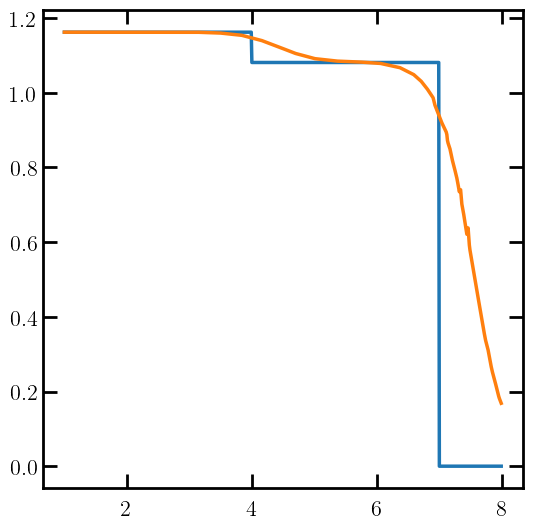

In [326]:
plt.figure()
plt.plot(rs_stuff, xe_func(rs_stuff))
plt.plot(rs_stuff, bump_interp(rs_stuff))

# Rates

In [264]:
mDM=8e8
DM_process='decay'
lifetime=2e22
cf=4
sigmav=3e-26
pri='phot_delta'

tmp_run = main.evolve(
    primary=pri,
    DM_process=DM_process, mDM=mDM, sigmav=sigmav, lifetime=lifetime,
    start_rs = 3000, end_rs=4.01,
    coarsen_factor=cf, backreaction=True,
    reion_switch = True, heat_switch=False,
    helium_TLA=True, reion_rs = 35, xe_reion_func = reion_interps['FlexKnot_late'],
    struct_boost=None
)

../darkhistory/history/reionization.py:360: RuntimeWarning: divide by zero encountered in log10
  gaunt_fac = 1.1 + 0.34 * np.exp(-(5.5 - np.log10(T_in_K))**2/3.0)


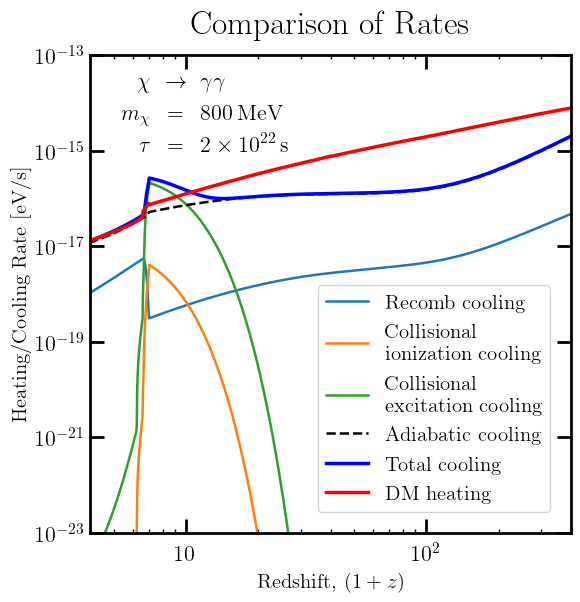

In [336]:
heat_arr=tmp_run['f']['low']['heat']+tmp_run['f']['high']['heat']
rs_vec = tmp_run['rs']
rates = []
for i,rs in enumerate(rs_vec):
    rates.append([
        reion.recomb_cooling_rate(
            tmp_run['x'][i,0], 
            tmp_run['x'][i,1], 0,
            tmp_run['Tm'][i],
            rs
        )/ (3/2 * phys.nH * rs**3 * (1 + phys.chi + sum(tmp_run['x'][i])))
        ,
        reion.coll_ion_cooling_rate(
            tmp_run['x'][i,0], 
            tmp_run['x'][i,1], 0,
            tmp_run['Tm'][i],
            rs
        )/ (3/2 * phys.nH * rs**3 * (1 + phys.chi + sum(tmp_run['x'][i])))
        ,
        reion.coll_exc_cooling_rate(
            tmp_run['x'][i,0], 
            tmp_run['x'][i,1], 0,
            tmp_run['Tm'][i],
            rs
        )/ (3/2 * phys.nH * rs**3 * (1 + phys.chi + sum(tmp_run['x'][i])))
        ,
        reion.brem_cooling_rate( 
            tmp_run['x'][i,0], 
            tmp_run['x'][i,1], 
            tmp_run['Tm'][i], 0,
            rs
        )/ (3/2 * phys.nH * rs**3 * (1 + phys.chi + sum(tmp_run['x'][i])))
        ,
        2*tmp_run['Tm'][i] / phys.dtdz(rs) / rs
        ,
        heat_arr[i] * phys.inj_rate(DM_process, rs, mDM=mDM, lifetime=lifetime, sigmav=sigmav)
            / (3/2 * phys.nH * rs**3 * (1 + phys.chi + sum(tmp_run['x'][i])))*(1+
                phys.struct_boost_func(model='pwave_NFW_no_subs')(rs)*0)
    ])
rates=np.array(rates)

plt.figure()
plt.loglog()
plt.axis([4,400,1e-23,1e-13])
plt.plot(rs_vec, -rates[:,0], label='Recomb cooling', linewidth=1.8)
plt.plot(rs_vec, -rates[:,1], label='Collisional \n ionization cooling', linewidth=1.8)
plt.plot(rs_vec, -rates[:,2], label='Collisional \n excitation cooling', linewidth=1.8)
# plt.plot(rs_vec, -rates[:,3], label='brem cooling')
plt.plot(rs_vec, -rates[:,4], label='Adiabatic cooling', linestyle = '--', color='k', linewidth=1.8)
plt.plot(rs_vec, -rates[:,0]-rates[:,1]-rates[:,2]-rates[:,3]-rates[:,4], label='Total cooling', color='blue')
plt.plot(rs_vec, rates[:,5], label='DM heating', color='red')
# plt.axvline(9.3, linestyle='--', color='k', linewidth=0.7)

txt = r"\begin{eqnarray*}" + \
    r"\chi &\to& \gamma \gamma \\" + \
    r"m_\chi &=& 800 \,\mathrm{MeV} \\" + \
    r"\tau &=& 2 \times 10^{22}\, \mathrm{s}" + \
    r"\end{eqnarray*}"
ax = plt.gca()
ax.text(12, 5e-15, txt,
         {'color': 'black', 'fontsize': 16, 'ha': 'center', 'va': 'center'})
          #'bbox': dict(boxstyle="round", fc=(.5,.5,.5,.02), ec="black", pad=0.33)})

plt.title('Comparison of Rates')
plt.xlabel('Redshift, $(1+z)$', fontsize=15)
plt.ylabel('Heating/Cooling Rate [eV/s]', fontsize=15)
plt.legend(fontsize=15)
plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/Late_Time_Energy_Injection/Paper/figs/rates_comparison2.pdf')
plt.show()

# HeIII Cross-Check

In [789]:
10**interp1d(
    log10m['elec'], 
    erebus_data['FreeStream_robust_Tanh_early_elec_decay']
)(log10m_tmp)/10**xcheck_data[key]

array([1.01072766, 1.03788587, 1.00855437, 1.00329353, 1.00806373,
       1.01662487, 1.01441977, 1.05330038, 1.05356136, 1.03515629,
       1.02866214, 1.00885974, 1.01789154, 1.01395251, 1.01706444,
       1.01801032, 1.01844197, 1.01680501, 1.01574057, 1.01741078,
       1.0162356 , 1.02157284, 1.02165517, 1.02009424, 1.01540503,
       1.01826733, 1.02195817])

In [800]:
len(xcheck_data[key])

27

In [833]:
output_dir = '/Users/gregoryridgway/Desktop/Junk/'
key = 'conservative_Tanh_early_elec_decay'

goods = pickle.load(open(output_dir+'CrossCheckHeIII_'+key+'.dat','rb'))

log10m_tmp = np.arange(6.01, 12.76, 0.1)
HeIII_data={}
HeIII_data[key] = np.zeros_like(log10m_tmp)

for i in np.arange(18):#len(xcheck_data[key])):
#     print(goods[0][i], goods[1][i][:-1])
    HeIII_data[key][i] = interp1d(
        goods[0][i], goods[1][i][:-1]
    )(10.1522)

In [841]:
erebus_data['FreeStream_robust_Tanh_early_elec_decay'][:18]/HeIII_data['conservative_Tanh_early_elec_decay'][:18]

array([1.00022951, 1.00100262, 1.00106579, 1.00002164, 1.00020586,
       1.00014642, 1.00013273, 1.00017367, 1.00010879, 1.00016177,
       1.00014118, 1.00022279, 1.00018815, 1.00026255, 1.00037966,
       1.0002701 , 1.00095453, 1.00131743])

In [ ]:
HeIII_data['conservative_Tanh_early_elec_decay']

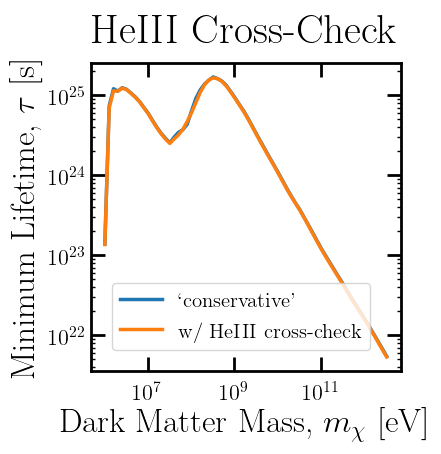

In [848]:
output_dir = '/Users/gregoryridgway/Desktop/Junk/'
key = 'conservative_Tanh_early_elec_decay'

goods = pickle.load(open(output_dir+'CrossCheck_'+key+'.dat','rb'))

log10m_tmp = np.arange(6.01, 12.76, 0.25)
xcheck_data={}
xcheck_data[key] = np.zeros_like(log10m_tmp)

for i in np.arange(len(xcheck_data[key])):
#     print(goods[0][i], goods[1][i][:-1])
    xcheck_data[key][i] = interp1d(
        goods[0][i], goods[1][i][:-1]
    )(10.1522)
   
erb_func = interp1d(log10m['elec'], erebus_data['FreeStream_robust_Tanh_early_elec_decay'], kind='cubic')
# xcheck_data[key][:2] = erb_func(log10m_tmp[:2])

xcheck_func1 = interp1d(log10m['elec'][:18],HeIII_data['conservative_Tanh_early_elec_decay'][:18])
xcheck_func2 = interp1d(log10m_tmp, xcheck_data[key], kind='cubic')
def xcheck_func(log10ms):
    tmp = np.zeros_like(log10ms)
    mask = (log10ms <= log10m['elec'][17])
    tmp[mask] = xcheck_func1(log10ms[mask])
    tmp[~mask] = xcheck_func2(log10ms[~mask])
    return tmp
    

plt.figure(figsize=(4,4))
plt.loglog()
plt.plot(10**log10_mDM_fine['elec'][:-2], 10**erb_func(log10_mDM_fine['elec'][:-2]), label="`conservative'")
plt.plot(10**log10_mDM_fine['elec'][:-2], 10**xcheck_func(log10_mDM_fine['elec'][:-2]), label="w/ HeIII cross-check")
           #s = 15.0)


plt.xlabel(r'Dark Matter Mass, $m_{\chi}$ [eV]', fontsize=24)
plt.ylabel(r'Minimum Lifetime, $\tau$ [s]', fontsize=24)
plt.title(r'HeIII Cross-Check', fontsize=30)

for k in [0,1]:
    for tick in axarr[k].xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in axarr[k].yaxis.get_major_ticks():
        tick.label.set_fontsize(24)
plt.legend(fontsize=15)

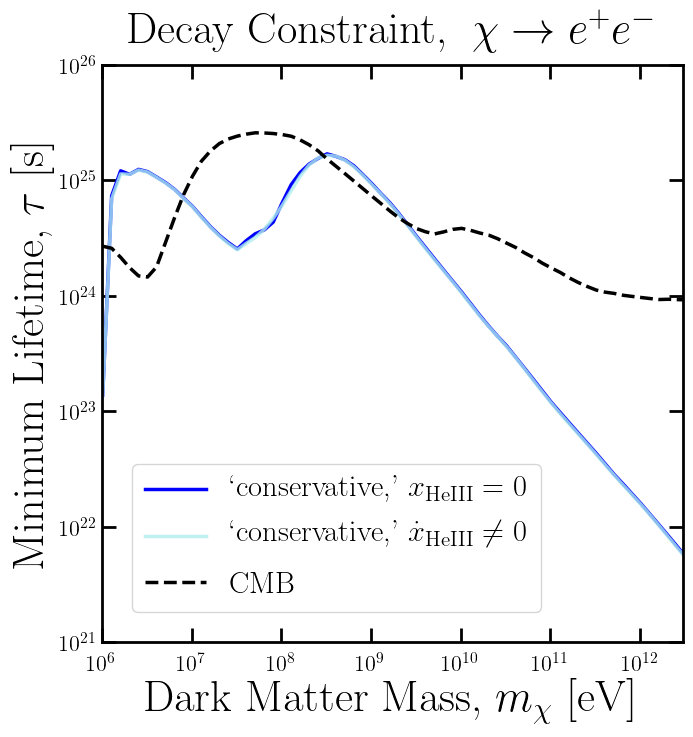

In [857]:
plt.figure(figsize=(7.5,7.5))
ax = plt.gca()
plt.loglog()
# fig, axarr = plt.subplots(2, 2, figsize=(15,16))

log10_m_chi_arr = {'phot': np.arange(4.01, 12.76, m_inc), 
                   'elec': np.arange(6.01, 12.76, m_inc)}
log10_mDM_fine = {'phot': np.arange(4.01,12.76,.1), 'elec': np.arange(6.01,12.76,.1)}
xsec_bound_CMB = {'phot': xsec_bound_phot_CMB, 'elec': xsec_bound_elec_CMB}

extra=part+'_'+inj_ty

kind='cubic'

output_dir = '/Users/gregoryridgway/Desktop/Junk/'
key = 'conservative_Tanh_early_elec_decay'

# goods = pickle.load(open(output_dir+'CrossCheck_'+key+'.dat','rb'))

log10m_tmp = np.arange(6.01, 12.76, 0.25)
xcheck_data={}
xcheck_data[key] = np.zeros_like(log10m_tmp)

for i in np.arange(len(xcheck_data[key])):
#     print(goods[0][i], goods[1][i][:-1])
    xcheck_data[key][i] = interp1d(
        goods[0][i], goods[1][i][:-1]
    )(10.1522)
   
erb_func = interp1d(log10m['elec'], erebus_data['FreeStream_robust_Tanh_early_elec_decay'], kind='cubic')

xcheck_func1 = interp1d(log10m['elec'][:18],HeIII_data['conservative_Tanh_early_elec_decay'][:18])
xcheck_func2 = interp1d(log10m_tmp, xcheck_data[key], kind='cubic')
def xcheck_func(log10ms):
    tmp = np.zeros_like(log10ms)
    mask = (log10ms <= log10m['elec'][17])
    tmp[mask] = xcheck_func1(log10ms[mask])
    tmp[~mask] = xcheck_func2(log10ms[~mask])
    return tmp

plt.plot(10**log10_mDM_fine['elec'][:-2], 
         10**erb_func(log10_mDM_fine['elec'][:-2]), 
         label=r"`conservative,' $x_{\mathrm{HeIII}} = 0$",
        color= 'blue')
plt.plot(10**log10_mDM_fine['elec'][:-2], 
         10**xcheck_func(log10_mDM_fine['elec'][:-2]), 
         label=r"`conservative,' $\dot{x}_{\mathrm{HeIII}} \neq 0$",
         color='paleturquoise',
         alpha=0.8)
           #s = 15.0)
ax.set_title(r'Decay Constraint, $\;\chi \to e^+e^-$', fontsize=32)

for k in [0,1]:
    for tick in axarr[k].xaxis.get_major_ticks():
        tick.label.set_fontsize(24)
    for tick in axarr[k].yaxis.get_major_ticks():
        tick.label.set_fontsize(24)


ax.set_xlabel(r'Dark Matter Mass, $m_\chi$ [eV]', fontsize=32)
CMB_data = [xsec_bound_CMB['elec'](mDM, 'decay') for mDM in 10**log10_mDM_fine['elec']]
ax.plot(10**log10_mDM_fine[part], CMB_data, color='k', linestyle='--', label='CMB')

#(0.02, 0.675)
ax.legend(loc=3, fontsize=22, ncol=1)

plt.axis([10**6, 3e12, 1e21,1e26])
ax.set_ylabel(r'Minimum Lifetime, $\tau$ [s]', fontsize=32)

plt.xticks()
# axarr[1].xaxis.set_tick_params(which='minor', bottom=False)
# axarr[1].xaxis.set_tick_params(which='minor', top=False)
ax.xaxis.set_tick_params(which='minor', bottom=False)
ax.xaxis.set_tick_params(which='minor', top=False)
ax.yaxis.set_tick_params(which='minor', left=False)
ax.yaxis.set_tick_params(which='minor', right=False)

# for tick in ax.xaxis.get_major_ticks():
#     tick.label.set_fontsize(26)
# for tick in ax.yaxis.get_major_ticks():
#     tick.label.set_fontsize(26)

plt.savefig('/Users/gregoryridgway/Dropbox (MIT)/Late_Time_Energy_Injection/Paper/figs/HeIII_xcheck.pdf')

# Temporary Crap

In [370]:
xe_reion_func = reion_interps['Tanh_early']

In [727]:
%autoreload
mDM = 10**(7.76)
tau = 10**(24.3)
DM_process='decay'
#tmp_hist Tanh_early
crap2 = main.evolve(
    primary='elec_delta',
    DM_process=DM_process, mDM=mDM, lifetime=tau,
    reion_switch=True, reion_rs=35, helium_TLA=True,
    xe_reion_func = reion_interps['Tanh_early'],
    start_rs = 3e3, end_rs=4.3, DeltaT=24665*phys.kB, alpha_bk=0.57,
    heat_switch=False,
    coarsen_factor=12, backreaction=True, 
    compute_fs_method='He', mxstep=1000, rtol=1e-4,
    use_tqdm=True, cross_check = False,
    struct_boost=None
)

In [700]:
reion_interps['Tanh_early']([9.22915567, 9.11906765])

array([0.91771662, 0.96837035])

In [706]:
not False

True

In [591]:
2*reion.alphaA_recomb('HeIII', 2e4*phys.kB)*phys.nH * phys.dtdz(5) * 2

-0.014921879819269164

In [713]:
crap3['x']

array([[9.99999999e-01, 7.88595679e-02, 1.00000000e-12],
       [9.99960189e-01, 8.09919181e-02, 9.99998695e-13],
       [9.99960189e-01, 8.09241455e-02, 9.99998695e-13],
       ...,
       [8.11225981e-02, 8.11225981e-02, 2.95404859e-02],
       [8.11225981e-02, 8.11225981e-02, 2.96340757e-02],
       [8.11225981e-02, 8.11225981e-02, 2.97220857e-02]])

Text(0, 0.5, 'Temperature, $T_m$ [K]')

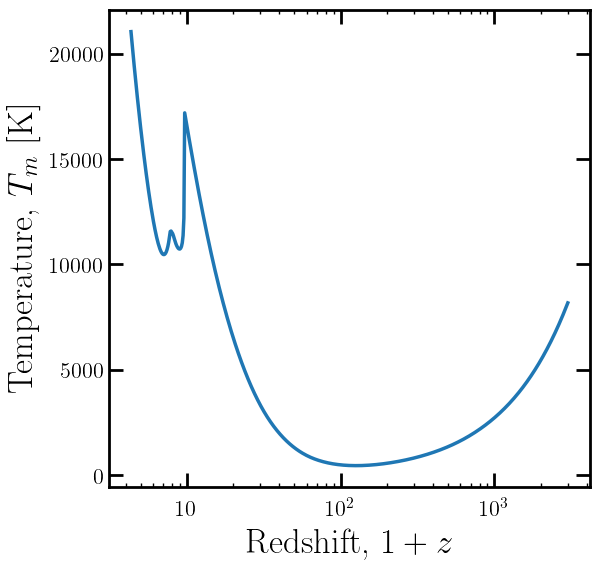

In [728]:
output = crap2

plt.figure()
plt.xscale('log')
# plt.axis([4,15, 1e3, 3e4])
plt.plot(output['rs'], output['Tm']/phys.kB)
plt.xlabel('Redshift, $1+z$', fontsize = 25)
plt.ylabel('Temperature, $T_m$ [K]', fontsize = 25)

In [662]:
output['rs'][-61:]

array([8.90281543, 8.7966201 , 8.69169149, 8.58801449, 8.48557419,
       8.38435583, 8.28434482, 8.18552678, 8.08788746, 7.99141282,
       7.89608895, 7.80190214, 7.70883881, 7.61688557, 7.52602917,
       7.43625653, 7.34755473, 7.25991098, 7.17331268, 7.08774735,
       7.00320266, 6.91966645, 6.83712668, 6.75557147, 6.67498908,
       6.59536789, 6.51669645, 6.43896342, 6.36215762, 6.28626797,
       6.21128356, 6.13719359, 6.06398738, 5.9916544 , 5.92018423,
       5.84956657, 5.77979126, 5.71084825, 5.64272761, 5.57541954,
       5.50891433, 5.44320242, 5.37827434, 5.31412074, 5.25073238,
       5.18810014, 5.12621499, 5.06506802, 5.00465044, 4.94495353,
       4.8859687 , 4.82768747, 4.77010142, 4.71320228, 4.65698185,
       4.60143204, 4.54654484, 4.49231234, 4.43872675, 4.38578034,
       4.3334655 ])

In [670]:
np.arange(1)

array([0])

In [723]:
output['x'][-61:,0]

array([0.95135703, 0.9673556 , 0.97782907, 0.98416016, 0.99036677,
       0.99272243, 0.99504999, 0.99734979, 0.99866909, 0.99910054,
       0.99952685, 0.99994807, 0.99996019, 0.99996019, 0.99996019,
       0.99996019, 0.99996019, 0.99996019, 0.99996019, 0.99996019,
       0.99996019, 0.99996019, 0.99996019, 0.99996019, 0.99996019,
       0.99996019, 0.99996019, 0.99996019, 0.99996019, 0.99996019,
       0.99996019, 0.99996019, 0.99996019, 0.99996019, 0.99996019,
       0.99996019, 0.99996019, 0.99996019, 0.99996019, 0.99996019,
       0.99996019, 0.99996019, 0.99996019, 0.99996019, 0.99996019,
       0.99996019, 0.99996019, 0.99996019, 0.99996019, 0.99996019,
       0.99996019, 0.99996019, 0.99996019, 0.99996019, 0.99996019,
       0.99996019, 0.99996019, 0.99996019, 0.99996019, 0.99996019,
       0.99996019])

Text(0, 0.5, 'HII Ionization Level, $x_{HII}$')

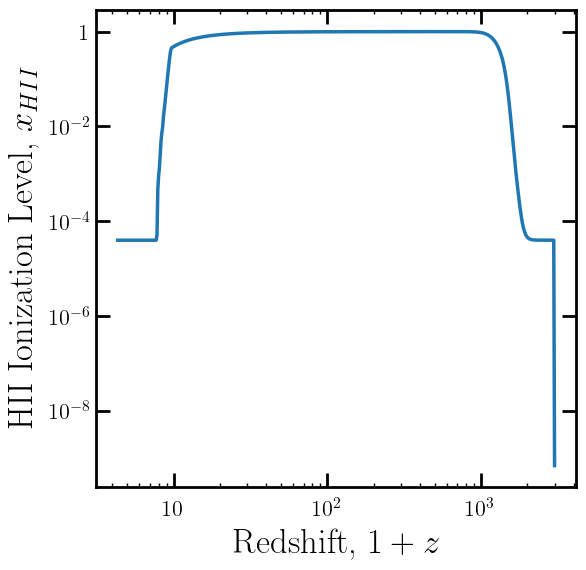

In [729]:
plt.figure()
# plt.xscale('log')
plt.loglog()
# plt.axis([4,15, 1e3, 3e4])
plt.plot(output['rs'], 1-output['x'][:,0])
plt.xlabel('Redshift, $1+z$', fontsize = 25)
plt.ylabel('HII Ionization Level, $x_{HII}$', fontsize = 25)

Text(0, 0.5, 'f$_{heat}$')

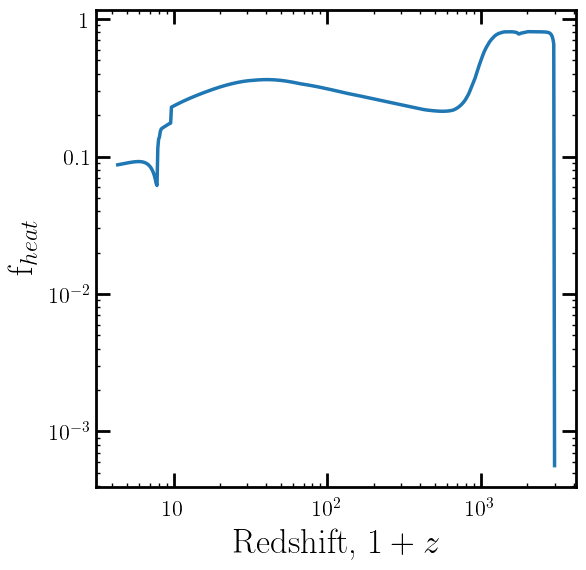

In [730]:
plt.figure()
plt.loglog()
plt.plot(output['rs'], output['f']['low']['heat'] + output['f']['high']['heat'])
plt.xlabel('Redshift, $1+z$', fontsize = 25)
plt.ylabel('f$_{heat}$', fontsize = 25)

In [414]:
import darkhistory.low_energy.lowE_photons as lowE_phot
n = phys.nH*spec.rs**3 * np.array([10**(-10.4), phys.chi*10**(-10.4), phys.chi*(1-10**(-4.4))])
mask = np.ones(500)
mask[152:175] = 0
lowE_phot.getf_ion(spec*mask, 1, 1, n, method = 'ion')

(6.865151151601161e-15, 1.859313214671607e-14, 0.003255999130487732)

In [735]:
ind = sum(eng < 4*phys.rydberg)-1

In [733]:
spec.N/(crap3['lowengphot'][-1].N+1e-100) - 1

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [736]:
crap2['lowengphot'][-1].N[ind]

5.4741771510146056e-05

In [737]:
crap3['lowengphot'][-1].N[ind]

5.3814783460252955e-05

Text(0.5, 1.0, 'Lowengphot at rs 4.33')

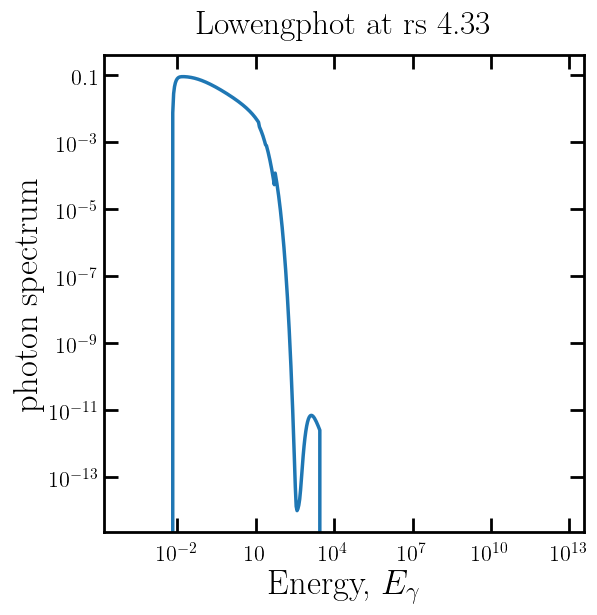

In [726]:
plt.figure()
plt.loglog()
spec = output['lowengphot'][-1]
eng = spec.eng
plt.plot(eng, spec.N)
plt.xlabel('Energy, $E_{\gamma}$', fontsize = 25)
plt.ylabel('photon spectrum', fontsize = 25)
plt.title('Lowengphot at rs '+str(spec.rs)[:4])

In [327]:
eng[171]

55.42682981602618

In [335]:
output['lowengphot'][-50].rs

7.801902136741109

In [344]:
dt/1e12

89.19752721825799

In [345]:
spec.rs

4.3334654970622415

In [350]:
1-output['x'][-1]

array([3.98107171e-05, 9.18877402e-01])

[10, 55, 0, 1.1]

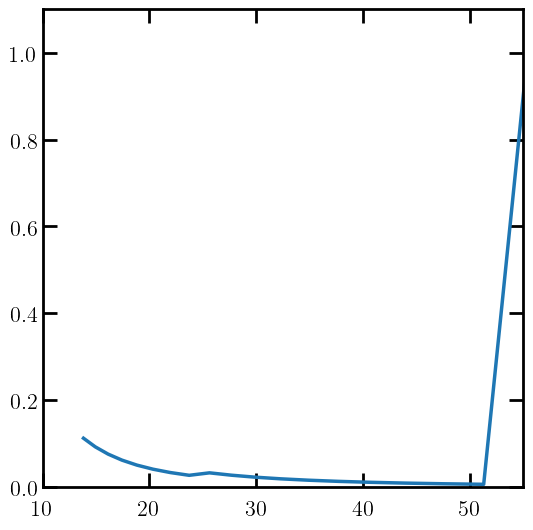

In [360]:
spec = output['lowengphot'][-1]
n = phys.nH*spec.rs**3*np.array([1-output['x'][-1,0], phys.chi-output['x'][-1,1]])
dt = 12*.001/phys.hubble(spec.rs)

ratios = np.array([
    n[i]*phys.photo_ion_xsec(eng, chan) * phys.c * dt
    for i,chan in enumerate(['HI', 'HeI'])
])

prop_fracs = np.exp(-np.sum(ratios, axis=0))
prop_fracs[eng>=54.4] = 0
prop_fracs[eng<=13.6] = 0

plt.figure()
plt.plot(eng[153:172], 1-prop_fracs[153:172])
plt.axis([10,55,0,1.1])

In [361]:
1-prop_fracs[153:172]

array([0.11215528, 0.09220512, 0.07553498, 0.06167915, 0.05021679,
       0.0407747 , 0.03302656, 0.02669042, 0.03236942, 0.02693891,
       0.02238658, 0.01857971, 0.01540316, 0.01275707, 0.01055535,
       0.00872448, 0.00720228, 0.0059368 , 1.        ])

In [362]:
n

array([6.14484981e-10, 4.98506028e-11])